In [1]:
#imports
import os
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
from numpy import reshape
from scipy import stats
import re
import ast

%matplotlib inline

In [247]:
def scrape(i):
    
    os.chdir('/Users/andrewcaffey/Documents/Projects/Data/PCPP/builds/builds_html')
    
    cvs_file_num = i
    
    build_dict_list = []
    
    batch_list = []
    for x in range(27):
        batch = range(1000)
        batch = [(1000*x) + group for group in batch]
        batch_list.append(batch)
    
    
    
    files = os.listdir(os.getcwd())

    for i in batch_list[i]:
        
        try: #some entries have been removed at the time of scraping

            
            a = open(files[i], "r")
            b = BeautifulSoup(a)

            #Parts

            #Labels
            labels = b.find('ul', attrs={"class":"parts"}).findAll('p', attrs={"label"})
            cols = [label.contents[0] for label in labels]
            count = [0 for x in range(len(cols))]

            #handle multiple parts of the same type (e.g. 2 graphics cards)

            for x in range(len(cols)):
                count[x] = 1+ cols[0:x].count(cols[x])

            new_cols = [str(x)+"_"+str(y) for (x,y) in zip(cols, count)]

            #Values (Names of parts)
            values = b.find('ul', attrs={"class":"parts"}).findAll('a', attrs={"name"})
            vals = [value.contents[0] for value in values]
            #cols = [label.contents[0] for label in labels]

            #Links
            link_list = b.find('ul', attrs={"class":"parts"}).findAll('a', attrs={"name"})
            link_list = [link['href'] for link in link_list]


            #Prices
            prices = b.find('ul', attrs={"class":"parts"}).findAll('div', attrs={"price"})
            price_list = [price.contents[0].strip() for price in prices]
            total_price = float(b.find("li",attrs={"class":"partlist-total"}).find('span', attrs={"class":"price"}).contents[0].strip("$"))
            total_price_dict = {"total":total_price}
            #print total_price

            build_part_dict = {part: {"Link":link,"Price":price,"Name":str(name)} for part, link, price, name in zip(new_cols, link_list, price_list,vals)}


            #description
            description_paragraphs = b.find('div', attrs={'class':'description block'}).find_all('p')
            description_clean = ''
            for paragraph in description_paragraphs:
                add = paragraph.text
                description_clean += add + ' '  
            
            description_dict = {'Description':description_clean}


            #Builder: 
            build_name = b.find('h1', attrs={"class":"name"}).contents[0]
            builder_link = b.find('p', attrs={"class":"owner"}).find('a')['href']
            builder_dict = {"Builder":build_name}
            owner_dict = {"Owner":builder_link}

            #Details

            detail_vals = [x.strip(u" ").strip(u'\n').strip() for x in b.find('div', attrs={"class":"part-details"}) if "\n " in x]

            details =  [x.contents[0] for x in b.find('div', attrs={"class":"part-details"}).find_all('h4')]

            detail_dict = {detail:detail_val for detail_val, detail in zip(detail_vals, details)}


            #Permalink

            perma_link = b.find('input', attrs={"type":"text"})['value'].split("/b/")[1]

            #create dictionary

            build_dict = {"Permalink": perma_link, "Builder":builder_link}

            #+total_price_dict.items()
            master_dict = dict(build_dict.items()+builder_dict.items()+build_part_dict.items()+detail_dict.items()+total_price_dict.items()+owner_dict.items() + description_dict.items())
            build_dict_list.append(master_dict)

            #append dictionary to dict_list
            
            b.decompose()
            a.close()
        
        except:
            pass

    df = pd.DataFrame(build_dict_list)
    os.chdir('/Users/andrewcaffey/Documents/Projects/Data/PCPP/builds/batches1/')
    df.to_csv('batch_' + str(cvs_file_num) + '.csv', encoding='utf-8')

In [31]:
scrape(1)

In [123]:
#watch out for .DS-Store
#change directory
os.chdir('/Users/andrewcaffey/Documents/Projects/Data/PCPP/builds/batches_test/')
csv_files = []
for i in os.listdir(os.getcwd()):
    df = pd.read_csv(i,index_col=None, header=0 )
    csv_files.append(df)
df = pd.concat(csv_files)

#figure out how to export this file type as a CSV file

In [109]:
#save df to local csv file
df.to_csv('build_csv.csv', encoding='utf-8', index=False)

In [16]:
os.chdir('/Users/andrewcaffey/Documents/Projects/Data/PCPP/builds/')
df1 = pd.read_csv('build_csv.csv', low_memory=False)

In [28]:
part_cols = [col for col in df1.columns if '_' in col]

In [29]:
len(part_cols)

141

In [23]:
part_cols = [col for col in df1.columns if 'Case F' in col]

In [27]:
len(df.columns)

440

In [24]:
len(part_cols)

32

In [3]:
#reset index (0,25158)
df.index = [x for x in range(df.index.shape[0])]

In [4]:
#check shape of dataframe
df.shape

(25851, 155)

In [6]:
#unpack part dictionaries
#ignores name, converts strings from CSV files to python dictionaries 

##check for errors in handling missing values: nan/None/0.00 etc
counter = 0
cols = [col for col in df.columns if '_' in col]
for x in cols:
    if ('_' in x):
        df[x] = [y.split(", u'Name':")[0]+ "}" if type(y)==str else {u'Price': u'$0.00', u'Link': u'',}  for y in df[x]]
        
        try:
            df[x] = [ast.literal_eval(y) if type(y)==str else {u'Price': u'$0.00', u'Link': u'',} for y in df[x]]
            counter += 1
        except:
            pass
print counter

141


In [7]:
cols = [col for col in df.columns if '_' in col]
for x in cols:
    
    df[x+'_price'] = [y[u'Price'] if type(y)==dict else None for y in df[x]]
    df[x+'_link'] = [y[u'Link'].split('/')[-1] if type(y)==dict else None for y in df[x]]

In [8]:
#cleaning

df['CPU Clock Rate'] = [x if type(x)==str else '0Ghz' for x in df['CPU Clock Rate']]
df['cpu_clock_rate'] = [float(re.sub(r'[A-Z]+', '', x.upper()))*1000 if 'GHZ' in x.upper() else float(re.sub(r'[A-Z]+', '', x.upper())) for x in df['CPU Clock Rate']]

df['cpuwhileIdle'] = [float(re.sub("[^0-9^.]", "", x)) if type(x) == str else 0 for x in df['CPU Temperature While Idle']]
df['cpuwhileLoad'] = [float(re.sub("[^0-9^.]", "", x)) if type(x) == str else 0 for x in df['CPU Temperature Under Load']]

In [9]:
#save df to local csv file
df.to_csv('master_build_csv5.csv', encoding='utf-8', index=False)

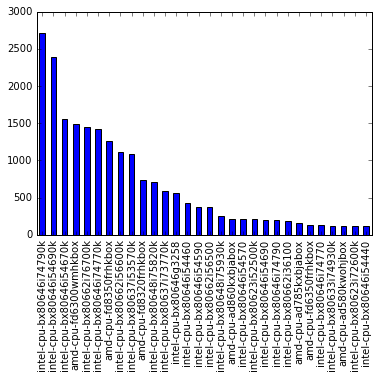

In [105]:
# note on how to keep index after a pandas merge: a.reset_index().merge(b, how="left").set_index('index')
result = pd.merge(df, cpu_df, on='short_link')
result.short_link.value_counts()[:30].plot(kind='bar', rot=45)

In [332]:
#get shortlinks for each part

link_cols = [x for x in df.columns if '_link' in x]
for x in link_cols:
    df[x] = [y.split('/')[-1] for y in df[x]]

In [333]:
#cleaning

df['CPU Clock Rate'] = [x if type(x)==str else '0Ghz' for x in df['CPU Clock Rate']]
df['cpu_clock_rate'] = [float(re.sub(r'[A-Z]+', '', x.upper()))*1000 if 'GHZ' in x.upper() else float(re.sub(r'[A-Z]+', '', x.upper())) for x in df['CPU Clock Rate']]

df['cpuwhileIdle'] = [float(re.sub("[^0-9^.]", "", x)) if type(x) == str else 0 for x in df['CPU Temperature While Idle']]
df['cpuwhileLoad'] = [float(re.sub("[^0-9^.]", "", x)) if type(x) == str else 0 for x in df['CPU Temperature Under Load']]